# Multivariate Normal Likelihood with Multivariate Normal Prior

This is a simple model where our data, $y$, is modelled as a multivariate normal RV with uncorrelated noise.

$L(x) = p(y | x) = \mathcal{N}[y \mid x,\Sigma]$

and

$p(x) = \mathcal{N}[x \mid \mu, \sigma^2 \mathbf{I}]$.

The analytic evidence for this model is,

$Z = p(y) = \mathcal{N}[y \mid \mu, \Sigma + \sigma^2 \mathbf{I}]$

The posterior is also a multivariate normal distribution,

$p(x \mid y) = \mathcal{N}[\mu', \Sigma']$

where

$\mu' = \sigma^2 \mathbf{I} (\sigma^2 \mathbf{I} + \Sigma)^{-1} y + \Sigma (
    \sigma^2 \mathbf{I} + \Sigma)^{-1}  \mu$

and

$\Sigma' = \sigma^2 \mathbf{I}  (\sigma^2 \mathbf{I}  + \Sigma)^{-1} \Sigma$


In [1]:

import tensorflow_probability.substrates.jax as tfp
from jax import random, numpy as jnp

from jaxns import ExactNestedSampler
from jaxns import Model
from jaxns import PriorModelGen, Prior
from jaxns import TerminationCondition

tfpd = tfp.distributions

INFO[2023-01-02 14:47:59,938]: Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO[2023-01-02 14:47:59,940]: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-01-02 14:47:59,941]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-01-02 14:47:59,942]: Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
INFO[2023-01-02 14:47:59,943]: Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
WARNING[2023-01-02 14:47:59,944]: No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
from jax._src.scipy.linalg import solve_triangular


def log_normal(x, mean, cov):
    L = jnp.linalg.cholesky(cov)
    dx = x - mean
    dx = solve_triangular(L, dx, lower=True)
    return -0.5 * x.size * jnp.log(2. * jnp.pi) - jnp.sum(jnp.log(jnp.diag(L))) - 0.5 * dx @ dx


# define our data and prior
ndims = 3
prior_mu = 2 * jnp.ones(ndims)
prior_cov = jnp.diag(jnp.ones(ndims)) ** 2

data_mu = jnp.zeros(ndims)
data_cov = jnp.diag(jnp.ones(ndims)) ** 2
data_cov = jnp.where(data_cov == 0., 0.99, data_cov)

true_logZ = log_normal(data_mu, prior_mu, prior_cov + data_cov)

J = jnp.linalg.solve(data_cov + prior_cov, prior_cov)
post_mu = prior_mu + J.T @ (data_mu - prior_mu)
post_cov = prior_cov - J.T @ (prior_cov + data_cov) @ J

print("True logZ={}".format(true_logZ))
print("True post_mu={}".format(post_mu))
print("True post_cov={}".format(post_cov))


True logZ=-4.964944362640381
True post_mu=[1.4974875 1.4974873 1.4974874]
True post_cov=[[0.25618196 0.24628097 0.24628086]
 [0.24628094 0.25618184 0.24628094]
 [0.24628088 0.24628098 0.2561819 ]]


In [3]:

def prior_model() -> PriorModelGen:
    x = yield Prior(tfpd.MultivariateNormalTriL(loc=prior_mu, scale_tril=jnp.linalg.cholesky(prior_cov)), name='x')
    return x


# The likelihood is a callable that will take
def log_likelihood(x):
    return log_normal(x, data_mu, data_cov)


model = Model(prior_model=prior_model,
              log_likelihood=log_likelihood)


In [4]:

# Create the nested sampler class. In this case without any tuning.
ns = exact_ns = ExactNestedSampler(model=model, num_live_points=200, num_parallel_samplers=1,
                                   max_samples=1e4)

termination_reason, state = exact_ns(random.PRNGKey(42),
                                     term_cond=TerminationCondition(live_evidence_frac=1e-4))
results = exact_ns.to_results(state, termination_reason)

# We can always save results to play with later
exact_ns.save_results(results, 'save.npz')
# loads previous results by uncommenting below
# results = load_results('save.npz')



--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 186493
# samples: 2261
# slices: 44800.0
# slices / acceptance: 28.0
# likelihood evals / sample: 82.5
# likelihood evals / slice: 4.1
--------
logZ=-4.86 +- 0.14
H=5.5
ESS=454
--------
x[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
x[0]: 1.5 +- 0.46 | 0.94 / 1.51 / 2.13 | 1.57 | -0.01
x[1]: 1.51 +- 0.47 | 0.92 / 1.53 / 2.12 | 1.56 | -0.0
x[2]: 1.5 +- 0.46 | 0.91 / 1.49 / 2.11 | 1.57 | 0.01
--------


WARNING[2023-01-02 14:48:16,795]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


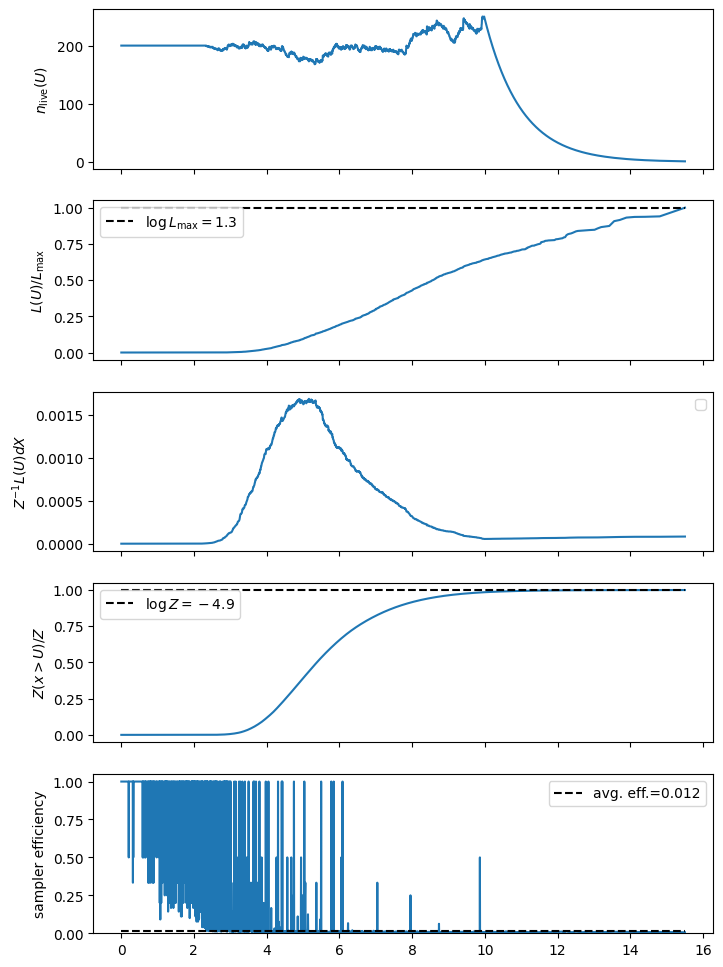

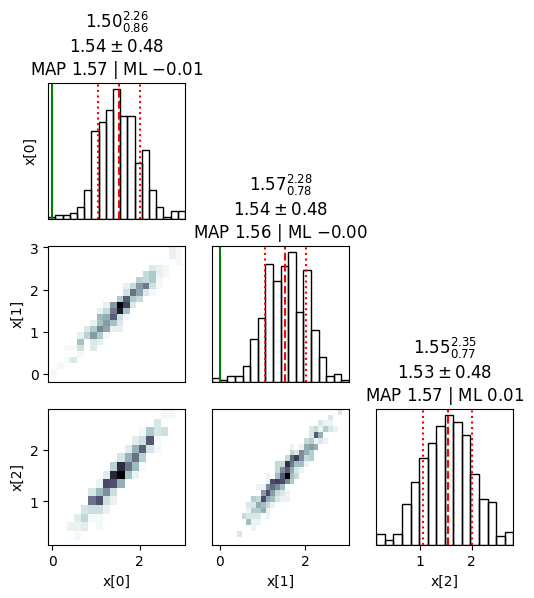

In [5]:
# We can use the summary utility to display results
exact_ns.summary(results)
# We plot useful diagnostics and a distribution cornerplot
exact_ns.plot_diagnostics(results)
exact_ns.plot_cornerplot(results)

In [6]:
from jaxns.tests.test_nested_sampler import Timer

with Timer():
    termination_reason, state = exact_ns(random.PRNGKey(42),
                                         term_cond=TerminationCondition(live_evidence_frac=1e-4))
    results = exact_ns.to_results(state, termination_reason)

Time to execute: 0.614554954 seconds.


In [7]:
from jaxns import marginalise_dynamic


# Let us now consider how to marginalise over the posterior.

def param_mean(x):
    return x


post_mean = marginalise_dynamic(random.PRNGKey(42),
                                samples=results.samples,
                                log_weights=results.log_dp_mean,
                                ESS=results.ESS,
                                fun=param_mean)


def param_covariance(x):
    dx = x - post_mean
    return jnp.outer(dx, dx)


post_covariance = marginalise_dynamic(random.PRNGKey(42),
                                      samples=results.samples,
                                      log_weights=results.log_dp_mean,
                                      ESS=results.ESS,
                                      fun=param_covariance)

print(f"Estimated posterior mean:\n{post_mean}")
print(f"True posterior mean:\n{post_mu}")

print(f"Estimated posterior covariance:\n{post_covariance}")
print(f"True posterior covariance:\n{post_cov}")

Estimated posterior mean:
[1.538716  1.5342478 1.5302073]
True posterior mean:
[1.4974875 1.4974873 1.4974874]
Estimated posterior covariance:
[[0.23020792 0.22343831 0.21862377]
 [0.22343831 0.23794274 0.22257836]
 [0.21862377 0.22257836 0.2276997 ]]
True posterior covariance:
[[0.25618196 0.24628097 0.24628086]
 [0.24628094 0.25618184 0.24628094]
 [0.24628088 0.24628098 0.2561819 ]]
